Problem 1 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import os
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']


def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []

    for i in range(1, 6):
        data_batch, label_batch = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        train_data.append(data_batch)
        train_labels.append(label_batch)

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

    return train_data, train_labels, test_data, test_labels

In [15]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc4(self.relu(self.fc3(x)))
        return x

In [16]:
if __name__ == "__main__":
    cifar10_dir = r'C:\Users\X390 Yoga\Desktop\Swayam\Intro to ML\cifar-10-python\cifar-10-batches-py'

    train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar10_dir)
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    train_data /= 255.0
    test_data /= 255.0

    trainloader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(list(zip(test_data, test_labels)), batch_size=64, shuffle=False)

Epoch 1, loss: 1.8844586885188852
Epoch 2, loss: 1.6957883081777627
Epoch 3, loss: 1.6058450463177907
Epoch 4, loss: 1.540079840918636
Epoch 5, loss: 1.500029304448296
Epoch 6, loss: 1.4610320136065373
Epoch 7, loss: 1.431117418019668
Epoch 8, loss: 1.401213950818152
Epoch 9, loss: 1.3744980410084395
Epoch 10, loss: 1.3543936831262104
Epoch 11, loss: 1.3254439173756962
Epoch 12, loss: 1.3024226585617455
Epoch 13, loss: 1.2855727045279939
Epoch 14, loss: 1.2647571267984103
Epoch 15, loss: 1.2480948874560158
Epoch 16, loss: 1.2262175929210986
Epoch 17, loss: 1.2123415025756181
Epoch 18, loss: 1.1947631807735815
Epoch 19, loss: 1.1743523476221371
Epoch 20, loss: 1.1571737014119277
Accuracy: 50.99 %
Precision: 0.5152304503690858
Recall: 0.5099
F1 Score: 0.5065609230249721


<Axes: >

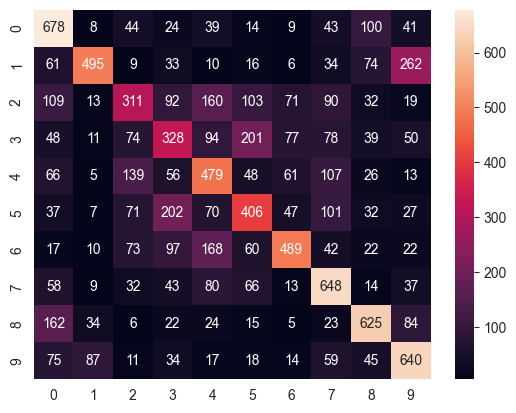

In [22]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 20
train_loss = []
train_accuracy = []
val_accuracy = []
val_loss = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}')

    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation accuracy
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    val_running_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(testloader))
    val_accuracy.append(100 * correct / total)

# Evaluating the model
y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy} %')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(conf_mat, annot=True, fmt='d')

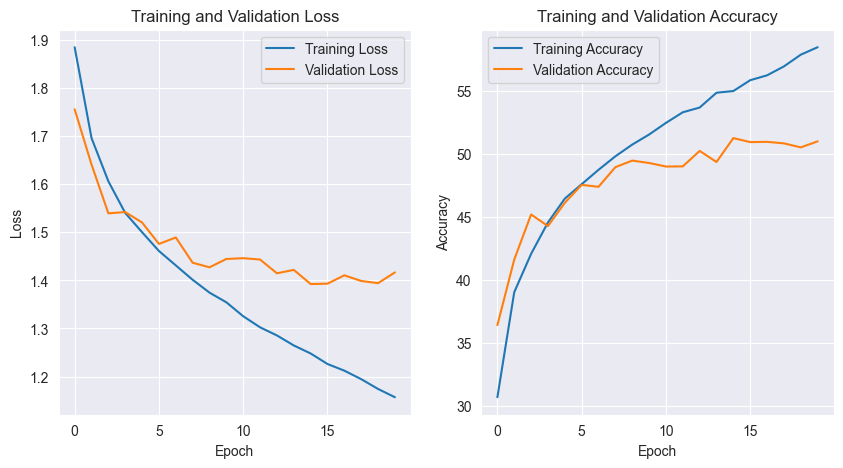

In [23]:
# Plotting training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1B

In [24]:
class MLP_extended(nn.Module):
    def __init__(self):
        super(MLP_extended, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)  # Increased width
        self.fc2 = nn.Linear(1024, 512)  # Increased width
        self.fc3 = nn.Linear(512, 256)  # Increased width
        self.fc4 = nn.Linear(256, 128)  # Increased width
        self.fc5 = nn.Linear(128, 64)  # Additional layer
        self.fc6 = nn.Linear(64, 10)  # Additional layer, output matches the number of classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc6(self.relu(self.fc5(x)))  # Pass through the additional layer
        return x

In [26]:
if __name__ == "__main__":
    cifar10_dir = r'C:\Users\X390 Yoga\Desktop\Swayam\Intro to ML\cifar-10-python\cifar-10-batches-py'

    train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar10_dir)
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    train_data /= 255.0
    test_data /= 255.0

    trainloader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(list(zip(test_data, test_labels)), batch_size=64, shuffle=False)

In [ ]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 20
train_loss = []
train_accuracy = []
val_accuracy = []
val_loss = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}')

    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation accuracy
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    val_running_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(testloader))
    val_accuracy.append(100 * correct / total)

# Evaluating the model
y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy} %')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(conf_mat, annot=True, fmt='d')

In [ ]:
# Plotting training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Problem 2

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [21]:
# Load dataset
df_train = pd.read_csv('C:/Users/SirM/Desktop/Swayam/Deep Learning/Intro-to-Deep-Learning/Datasets/house-train.csv')
df_test = pd.read_csv('C:/Users/SirM/Desktop/Swayam/Deep Learning/Intro-to-Deep-Learning/Datasets/house-test.csv')

# Define useful columns and preprocess the dataset
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
                'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
                'OpenPorchSF']
target_col = 'SalePrice'

df_train_prepro = df_train[usefull_cols + [target_col]].copy()

# Handle missing values
df_train_prepro.fillna(df_train_prepro.mean(), inplace=True)

# Split dataset into features and target
X = df_train_prepro[usefull_cols]
y = df_train_prepro[target_col]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.fc3(x)


model = MLP(len(usefull_cols))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/SirM/Desktop/Swayam/Deep Learning/Intro-to-Deep-Learning/Datasets/house-train.csv'